In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import pyremo as pr
import glob
from REMO2020_mod import modelclass, season_mean, open_mfdataset

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernelR2020/share/proj failed


In [2]:
# give figure path
figpath = './figures/'

In [3]:
# REMO, calipso and era5 datapaths
rdata = './data_in/model_data/iwc/'
caldata = './data_in/CALIPSO-IWC/'
e5data = './data_in/ERA5/'

In [4]:
# Define years for ERA5 (data from 06-2006 to 12-2020)
calyears = [2006,2020]

In [5]:
# Define years for ERA5 (data from 01-2001 to 12-2010)
remoyears = [2001,2010]

In [6]:
# Define years for REMO (data from 01-2001 to 12-2010)
era5years = [2001,2010]

In [7]:
# prepare cal files
calfilenames = glob.glob(caldata+"CAL_LID_L3_Ice_Cloud-Standard-V1-00.*nc4")
calfilenames.sort()

In [8]:
# open calipso data
dscal = open_mfdataset(calfilenames, parallel=False, chunks='auto')

In [9]:
# prepare ERA5 files
era5filenames = glob.glob(e5data+"IWC/ERA5p1_CALIPSO-GOCCP_IWC_*.nc")
era5filenames.sort()

In [10]:
# open era5
dsera5 = pr.parse_dates(open_mfdataset(era5filenames, parallel=False, chunks='auto'))

In [11]:
# define the runs to be plotted
modelruns =[] # init
modelruns.append(modelclass("056524","REMO2015",False,"var334"))
modelruns.append(modelclass("036030","REMO2020$_{27}$",True,"QI"))
modelruns.append(modelclass("036032","REMO2020$_{49}$",True,"QI"))

In [12]:
# Set halo zone length (will be cutted out)
halo = 8

In [13]:
# open remo data
for obj in modelruns:
    dstmp = pr.parse_dates(xr.open_dataset(rdata+obj.userexp+"_QI_hlevs_2001-2010.nc"))
    obj.vardiff = season_mean(dstmp.sel(time=slice(str(remoyears[0]), str(remoyears[1])))[[obj.varname]])
    obj.vardiff = obj.vardiff.isel(rlat=slice(halo+1,obj.vardiff.sizes["rlat"]-halo+1), rlon=slice(halo+1,obj.vardiff.sizes["rlon"]-halo+1)).compute()
    if(obj.r2020file):
        # get pole
        pole = (dstmp.rotated_latitude_longitude.grid_north_pole_longitude,dstmp.rotated_latitude_longitude.grid_north_pole_latitude)
        # calculate absolute mins/maxs for real coorindates (we use these to cut the global data)
        min_lon = np.min(obj.vardiff.lon.values)
        max_lon = np.max(obj.vardiff.lon.values)
        min_lat = np.min(obj.vardiff.lat.values)
        max_lat = np.max(obj.vardiff.lat.values)
        # calculate average latitudes for plotting
        avg_lats = obj.vardiff.lat.mean(dim="rlon")

In [14]:
# change the rotated coordinates and make zonal mean
for obj in modelruns:
    obj.vardiff = obj.vardiff.mean(dim=("rlon"))
    obj.vardiff = obj.vardiff.rename({"rlat": "latitude"})
    obj.vardiff["latitude"] = avg_lats

In [15]:
# make zonal mean for calipso
dscal_lonmean = season_mean(dscal.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)).sel(time=slice(str(calyears[0]), str(calyears[1]))).mean(dim=("lon")))

In [16]:
# make era5 zonal mean
dsera5_lonmean = season_mean(dsera5.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon)).sel(time=slice(str(era5years[0]), str(era5years[1]))).mean(dim=("lon")))

In [17]:
# Define the order of seasons to be used (also when plotting)
seasons = ["DJF","MAM","JJA","SON"]

/tmp/ipykernel_586490/836147361.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmappi = mpl.cm.get_cmap("jet",256)
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/tmp/ipykernel_586490/836147361.py:53: UserWarning: Log scale: values of z <= 0 have been masked
  cp = plt.contourf(dscal_lonmean.sel(season=seas).lat.values,dscal_lonmean.sel(season=seas).alt.values,dscal_lonmean.sel(season=seas).Ice_Water_Content_Grid_Average.transpose(), levels=levels, cmap=cmappi, extend='max', norm = LogNorm())
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)

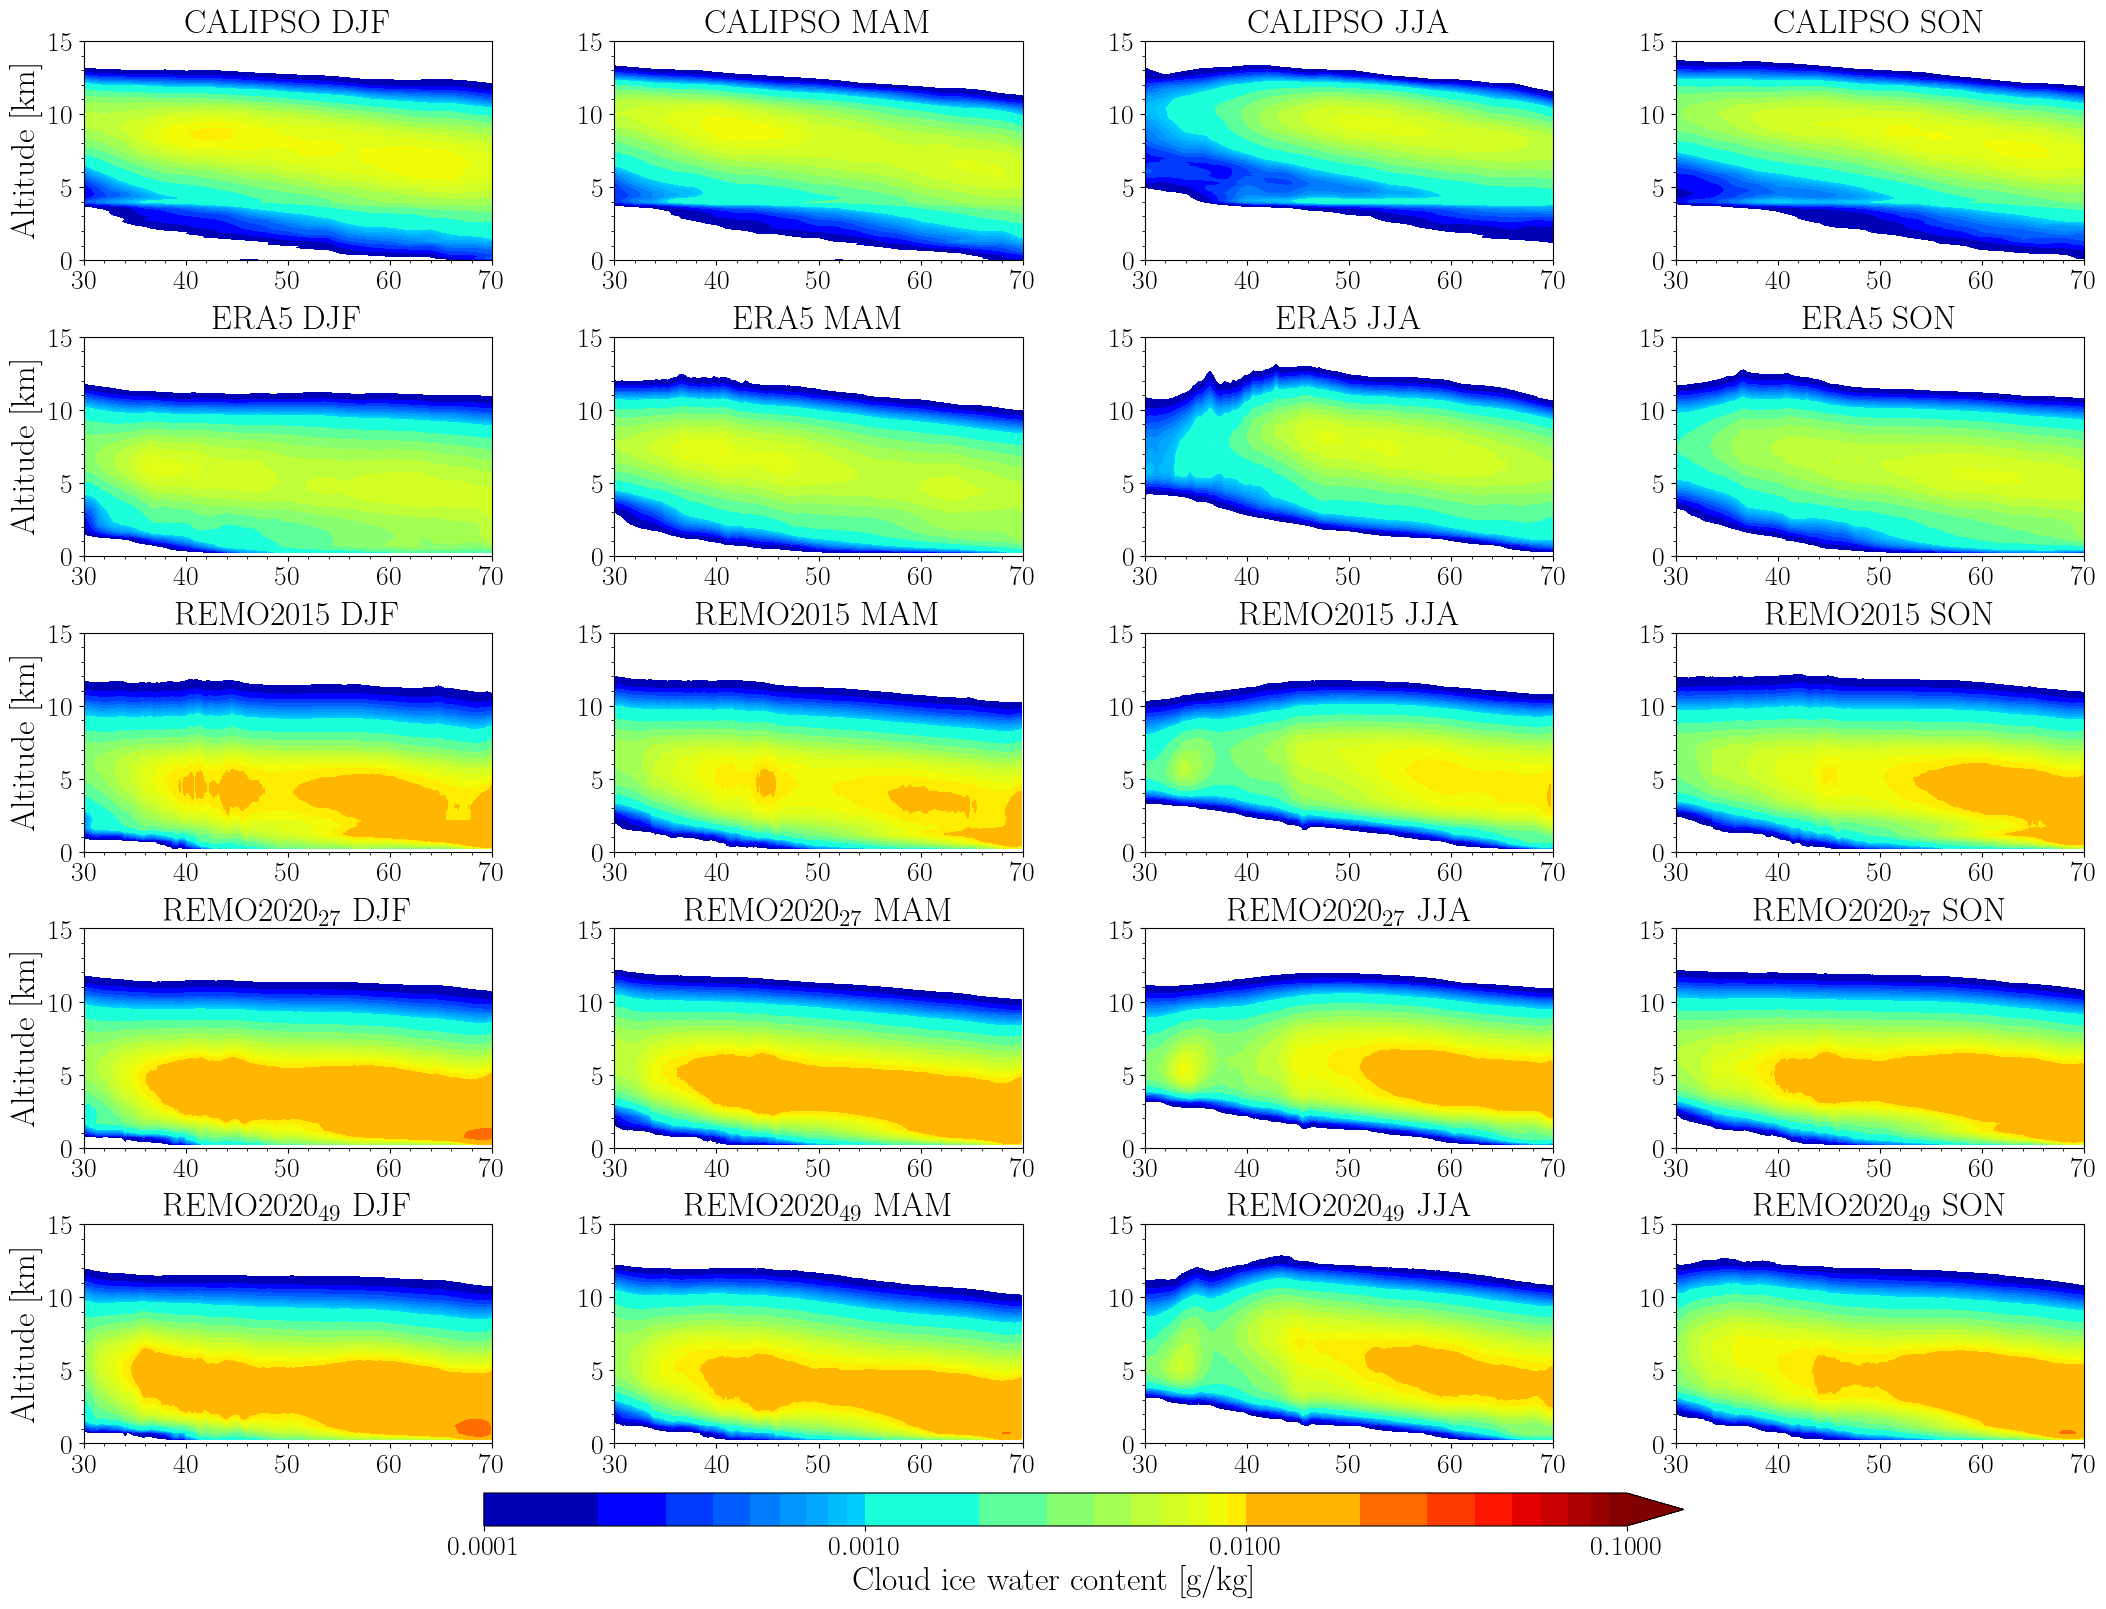

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20, (len(modelruns))*5.5)
plt.rcParams["figure.subplot.hspace"] = 0.35 # the amount of height reserved for white space between subplots
plt.rcParams["figure.subplot.wspace"] = 0.3 # the amount of width reserved for blank space between subplots
plt.rcParams["axes.titlesize"] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 24

gs = gridspec.GridSpec(len(modelruns)+2,4)
#gs.update(left=0.1, right=0.9, hspace=haspace, wspace=vaspace)                         

fig=plt.figure()
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=1.0, left=0, right=1.0)

# xlim, xticks and xticklabels
xlimmi = [30,70]
xtickki = [35,45,55,65]
xtickkilab = [str(ii)+"N" for ii in xtickki]

# ylim
ylimmi = [0,15]

# number of clorbar bins
nbins=100

# contour levels
levels = [1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,\
          1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,\
          1e-2,2e-2,3e-2,4e-2,5e-2,6e-2,7e-2,8e-2,9e-2,\
          1e-1]

# cut limit for white color (everything below this)
# If levels[1] is used, then the first bin is white
ccut = levels[1]

# create custom colormap
cmappi = mpl.cm.get_cmap("jet",256)

sb=[]
ii=-1
jj=0
# calipso data
for seas in seasons:
    ii=ii+1
    jj=jj+1
    sb = np.append(sb,plt.subplot(gs[ii]))
    # contour plot
    cp = plt.contourf(dscal_lonmean.sel(season=seas).lat.values,dscal_lonmean.sel(season=seas).alt.values,dscal_lonmean.sel(season=seas).Ice_Water_Content_Grid_Average.transpose(), levels=levels, cmap=cmappi, extend='max', norm = LogNorm())
    # Get axes
    ax = plt.gca()
    plt.title("CALIPSO "+seas)
    # xlim
    plt.xlim(xlimmi)
    # set minor ticks on
    plt.minorticks_on()
    # set y-label
    if(jj==1):
        plt.ylabel("Altitude [km]")
    # ylimit
    plt.ylim(ylimmi)

jj=0
# era5
for seas in seasons:
    ii=ii+1
    jj=jj+1
    sb = np.append(sb,plt.subplot(gs[ii]))
    # contour plot (note unit change from m to km and kg/kg to g/kg)
    cp = plt.contourf(dsera5_lonmean.sel(season=seas).lat.values,dsera5_lonmean.sel(season=seas).height.values/1000.0,dsera5_lonmean.sel(season=seas).ciwc.transpose()*1000.0, levels=levels, cmap=cmappi, extend='max',norm = LogNorm())
    # Get axes
    ax = plt.gca()
    plt.title("ERA5 "+seas)
    # xlim
    plt.xlim(xlimmi)
    # set minor ticks on
    plt.minorticks_on()
    # set y-label
    if(jj==1):
        plt.ylabel("Altitude [km]")
    # ylimit
    plt.ylim(ylimmi)

# model data
for obj in modelruns:
    jj = 0
    for seas in seasons:
        ii=ii+1
        jj=jj+1
        sb = np.append(sb,plt.subplot(gs[ii]))
        # contour plot (note unit change from m to km and kg/kg to g/kg)
        cp = plt.contourf(obj.vardiff.sel(season=seas).latitude.values,obj.vardiff.sel(season=seas).height.values/1000.0,obj.vardiff.sel(season=seas)[obj.varname]*1000.0, levels=levels, cmap=cmappi, extend='max',norm = LogNorm())
        # Get axes
        ax = plt.gca()
        # Title
        plt.title(obj.runame+" "+seas)
        # xlim
        plt.xlim(xlimmi)
        # set minor ticks on
        plt.minorticks_on()
        # set y-label
        if(jj==1):
            plt.ylabel("Altitude [km]")
        # ylimit
        plt.ylim(ylimmi)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
    
# Draw the colorbar
cbar=fig.colorbar(cp, cax=cbar_ax,orientation='horizontal',ticks=[0.0001,0.001,0.01,0.1],format=mticker.ScalarFormatter())
cbar.set_label('Cloud ice water content [g/kg]', fontsize=24)
# Save figure
figname = 'CIWC_CALIPSOERA5p1_CAL_'+str(calyears[0])+'-'+str(calyears[1])+'_ERA_'+str(era5years[0])+'-'+str(era5years[1])+'_REMO_'+str(remoyears[0])+'-'+str(remoyears[1])+'.png'
plt.savefig(figpath+figname,format="png",bbox_inches='tight', pad_inches=0)